# Фильтрация в частотной области

**Автор:** Винник Екатерина Петровна

## Основы фильтрации в частотной области

Последовательность шагов при фильтрации в частотной области:
1. Для заданного изображения $f(x, y)$ размерами $M×N$ вычислить значения параметров расширения $P$ и $Q$. Как правило, мы выбираем $P = 2M$ и $Q = 2N$.
2. Сформировать расширенное изображение $f(x, y)$ размерами $P×Q$ добавлением к $f(x, y)$ необходимого числа нулей.
3. Умножить $f_p(x, y)$ на $(–1)^{x+y}$ чтобы центрировать его Фурье-образ. Как отмечалось ранее, центрирование упрощает построение фильтр-функций и улучшает визуализацию процесса фильтрации, но не является существенным требованием.
4. Вычислить $F(u,v)$ — прямое ДПФ изображения, полученного на шаге 3.
$$
\begin{equation}
F(u, v) = \sum_{x=0}^{H-1} \sum_{y=0}^{W-1} f(x, y) e^{-j2\pi (ux/H + vy/W)},
\tag{1}
\end{equation}
$$
5. Сформировать действительную симметричную фильтр-функцию $H(u, v)$ размерами P×Q с центром в точке (P/2, Q/2).21 Вычислить произведение $G(u,v) = H(u,v)F(u,v)$, используя поэлементное произведение массивов, т. е. $G(i, k) = H(i, k)F(i, k)$.
6. Получить обработанное изображение при помощи вычисления обратного ДПФ 
$$
g_p(x, y) = {real[\zeta^{(-1)}[G(u, v)]]}(-1)^{(x+y)}
$$, 
в котором, чтобы убрать паразитную мнимую компоненту, возникающую из-за неточностей вычислений берется лишь действительная часть; нижний индекс p означает, что это расширенный массив.
7. Получить окончательный результат обработки $g(x, y)$ вырезанием области размерами $M×N$ из левого верхнего угла $g_p(x, y)$.

Поскольку частота прямо связана со скоростью пространственных изменений сигнала, то интуитивно ясно, что частоты в Фурье-преобразовании связаны с вариацией яркости на изображении. Наиболее медленно меняющаяся (постоянная) частотная составляющая $(u = v = 0)$ пропорциональна средней яркости изображения. Низкие частоты, отвечающие точкам вблизи начала координат Фурье-преобразования, соответствуют медленно меняющимся компонентам изображения. На изображении комнаты, например, они могут соответствовать плавным изменениям яркости стен и пола. По мере удаления от начала координат более высокие частоты начинают соответствовать все более и более быстрым изменениям яркости, которые суть границы объектов и другие детали изображения, характеризуемые резкими изменениями яркости.


#### Реализация

#### Дискретное преобразование Фурье (ДПФ)

In [1]:
import numpy as np
def get_dft(img, shift=False):
    height = img.shape[0]
    width = img.shape[1]
    img_dft = np.zeros_like(img, dtype=complex)
    img = img.astype(complex)
    
    x_arr = np.arange(height)
    y_arr = np.arange(width)
    
    x_mat = np.repeat(x_arr.reshape((height, 1)), width, 1)
    y_mat = np.repeat(y_arr.reshape((1, width)), height, 0)
    
    if shift:
        exp_val = (x_mat + y_mat) * np.pi * 1j
        img = np.multiply(img, np.exp(exp_val))
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        for ch in range(channels):
            for u in range(height):
                for v in range(width):
                    exp_val = -(u * x_mat / height + v * y_mat / width) * np.pi * 2j
                    img_dft[u, v] = np.sum(np.multiply(img[:, :, ch], np.exp(exp_val)))
    else:
         for u in range(height):
            for v in range(width):
                exp_val = (u * x_mat / height + v * y_mat / width) * np.pi * 2j
                img_dft[u, v] = np.sum(np.multiply(img, np.exp(exp_val)))          
    return img_dft

#### Обратное преобразование Фурье

In [2]:
import numpy as np
def get_idft(img_dft, shift=False):
    height = img_dft.shape[0]
    width = img_dft.shape[1]
    img_idft = np.zeros_like(img_dft, dtype=complex)
    img_dft = img_dft.astype(complex)
    
    u_arr = np.arange(height)
    v_arr = np.arange(width)
    
    u_mat = np.repeat(u_arr.reshape((height, 1)), width, 1)
    v_mat = np.repeat(v_arr.reshape((1, width)), height, 0)
     
    if shift:
        exp_val = (u_mat + v_mat) * np.pi * 1j
        img_dft = np.multiply(img_dft, np.exp(exp_val))
        
    if len(img_dft.shape) == 3:
        channels = img_dft.shape[-1]
        for ch in range(channels):
            for x in range(height):
                for y in range(width):
                    exp_val = (x * u_mat / height + y * v_mat / width) * np.pi * 2j
                    img_idft[x, y] = np.sum(np.multiply(img_dft[:, :, ch], np.exp(exp_val)))
    else:
        for x in range(height):
            for y in range(width):
                exp_val = (x * u_mat / height + y * v_mat / width) * np.pi * 2j
                img_idft[x, y] = np.sum(np.multiply(img_dft, np.exp(exp_val)))
    
    img_idft /= (height * width)  
    return img_idft

### Результаты применения фильтрации в частотной области к изображениям

Загрузим изображения для дальнейшей обработки. Загрузим довольно простые изображения, чтобы лучше описать отношения между частотной и пространственной областями.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


img_1 = Image.open('./1.png')
img_2 = Image.open('./stp1.gif')

In [4]:
# represent the images as tensors
np_1 = np.array(img_1)
np_2 = np.array(img_2)
print('Picture dimensions:')
print(np_1.shape)
print(np_2.shape)

Picture dimensions:
(32, 32)
(64, 64)


Применим ДПФ к изображениям:

In [5]:
np_1_dft = get_dft(np_1)

In [6]:
np_2_dft = get_dft(np_2)

In [7]:
# log of abs

np_1_dft_logabs = np.log(np.abs(np_1_dft))
np_2_dft_logabs = np.log(np.abs(np_2_dft))

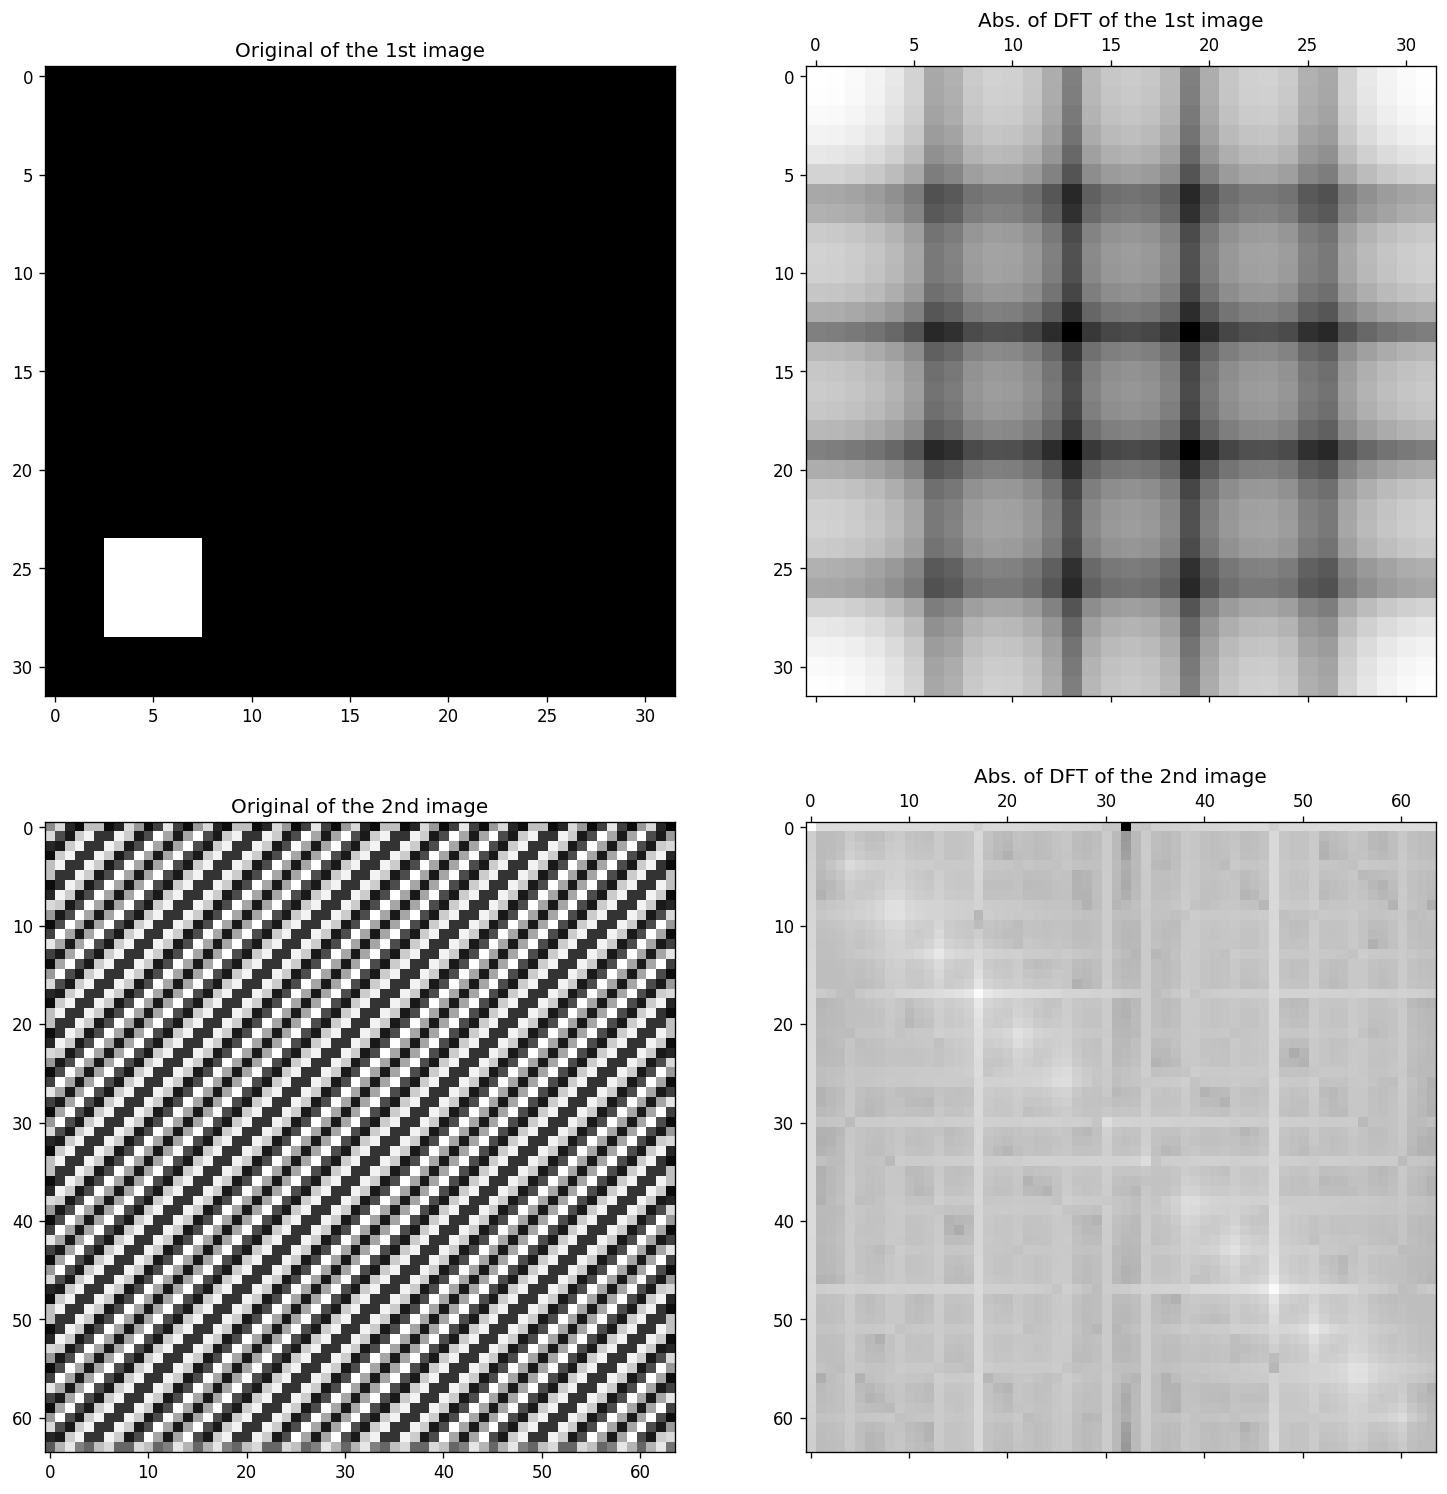

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].matshow(np_1_dft_logabs, cmap='gray')
axs[0, 1].set_title('Abs. of DFT of the 1st image')
axs[1, 0].imshow(np_2, cmap='gray')
axs[1, 0].set_title('Original of the 2nd image')
axs[1, 1].matshow(np_2_dft_logabs, cmap='gray')
axs[1, 1].set_title('Abs. of DFT of the 2nd image')
plt.show()

Результирующие изображения симметричны относительно начала координат в силу того, что преобразование периодично. Низкие частоты в начале координат изображений соответствуют медленно меняющимся компонентам изображения.  Высокие частоты отражают резкие перепады яркости, как горизонтальные, так и вертикальные. Центр изображения серого цвета, так как само изображение неоднородно, в нем присутствуют перепады яркости.


Основными компонентами второго преобразованного изображения являются центральное значение и две точки, соответствующие частоте полос. Белые точки на диагонали, перпендикулярной диагоналям исходного изображения, свидетельствуют о том, что в направлении этой диагонали присутствуют наибольшие перепады яркости. Логарифмическое преобразование преобразования Фурье для второго преобразованного изображения также показывает, что теперь изображение содержит много второстепенных частот. Основная причина в том, что диагональ может быть аппроксимирована только квадратными пикселями изображения, следовательно, для составления изображения необходимы дополнительные частоты. Логарифмическое масштабирование затрудняет определение влияния отдельных частот в исходном изображении.

## Фильтр-пробка

Фильтры, пропускающие определенную полосу частот, называют полосовыми фильтрами или полосовыми пропускающими фильтрами. Фильтры, задерживающие определенную полосу частот, называют полосовыми заграждающими (или режекторными) фильтрами; узкополосный заграждающий фильтр иногда называют *фильтром-пробкой* (*notch filter*). Чтобы применить такой фильтр, мы используем операцию свертки в пространственной области, которая соответствует умножению в частотной области:

$$
\begin{equation}
f(x, y) * h(x, y) \iff F(u, v) H(u, v),
\end{equation}
$$
где $*$ операция свертки, $f(x,y)$ и $F(u, v)$ исходное изображение и Фурье-изображение, $h(x, y)$ и $H(u, v)$ -- фильтр и его представление в частотной области, полученное с помощью ДПФ. Простейший фильтр-пробка может быть задан следующим образом:
$$
\begin{equation}
H(u, v) = 
\begin{cases}
      0, & \text{if}\ u = H/2, v = W/2 \\
      1, & \text{otherwise}
    \end{cases}
\end{equation}
$$

### Реализация

#### Фильтр-пробка

In [9]:
import numpy as np


def apply_cr_H(img_dft, size=3):
    h2 = img_dft.shape[0] // 2
    w2 = img_dft.shape[1] // 2
    
    img_dft[h2-size:h2+size+1, w2-size:w2+size+1] = 0.j
    
    return(img_dft)

### Результаты применения фильтра-пробки к изображениям

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


img_21 = Image.open('./int.jpg')
img_22 = Image.open('./flux.jpg')

In [11]:
# represent the images as tensors
np_21 = np.array(img_21)
np_22 = np.array(img_22)
print('Picture dimensions:')
print(np_21.shape)
print(np_22.shape)

Picture dimensions:
(128, 128, 3)
(128, 128, 3)


In [12]:
# simplify the images by summing the channels
np_21_sum = np.sum(np_21, axis=2)
np_22_sum = np.sum(np_22, axis=2)

Применим дискретное преобразование Фурье к изображениям:

In [13]:
np_21_dft = get_dft(np_21_sum, True)

In [14]:
np_22_dft = get_dft(np_22_sum, True)

In [15]:
np_21_dft_h = apply_cr_H(np_21_dft, 3)
np_22_dft_h = apply_cr_H(np_22_dft, 3)

Применим обратное преобразование Фурье:

In [16]:
np_21_idft = get_idft(np_21_dft_h)

In [17]:
np_22_idft = get_idft(np_22_dft_h)

In [18]:
np_21_idft_abs = np.abs(np_21_idft)
np_22_idft_abs = np.abs(np_22_idft)

In [19]:
np_21_idft_abs /= np.max(np_21_idft_abs)
np_22_idft_abs /= np.max(np_22_idft_abs)

In [20]:
np_21_idft_abs[np_21_idft_abs < 0] = 0.
np_22_idft_abs[np_22_idft_abs < 0] = 0.

In [21]:
np_21_idft_abs = np.rot90(np.rot90(np_21_idft_abs))
np_22_idft_abs = np.rot90(np.rot90(np_22_idft_abs))

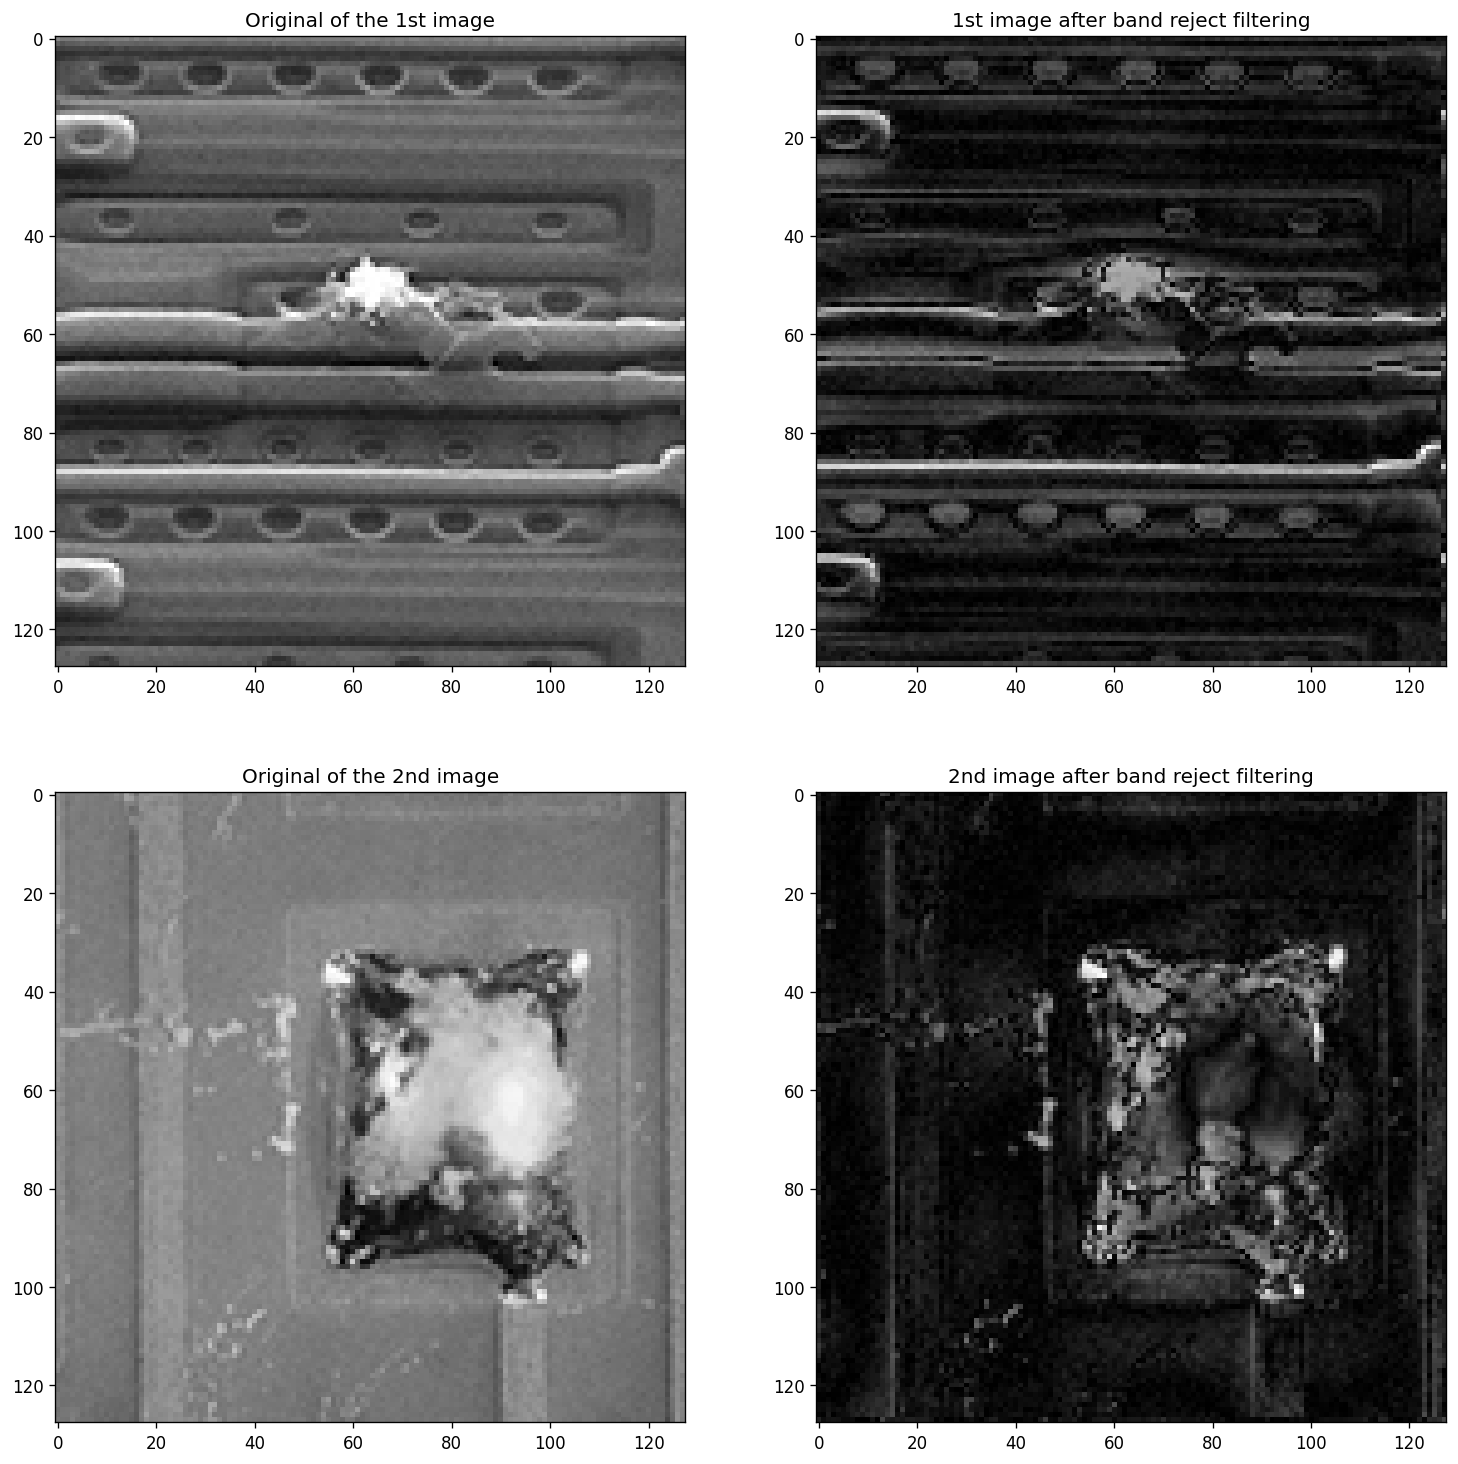

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_21_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_21_idft_abs, cmap='gray')
axs[0, 1].set_title('1st image after band reject filtering')
axs[1, 0].imshow(np_22_sum, cmap='gray')
axs[1, 0].set_title('Original of the 2nd image')
axs[1, 1].imshow(np_22_idft_abs, cmap='gray')
axs[1, 1].set_title('2nd image after band reject filtering')
plt.show()

Применение фильтра-пробки позволило лучше распознать дефекты на цепях, так как изображение стало темнее. Так произошло вследствие того, что постоянная составляющая определяет среднюю яркость изображения, так что приравнивая ее к нулю, средняя яркость выходного изображения уменьшается до нуля, и, следовательно,  результирующее изображение становится намного темнее. 